In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [2]:
import utils.metrics as utils_metrics

In [4]:
import hashlib

In [3]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [5]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [6]:
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [7]:
evaluate_metrics = utils_metrics.evaluate_metrics_for_algorithm

In [8]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [9]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [29]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 87.6792%
WER: 13.2758%
Mean overlap: 3.833


In [30]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [37]:
from typing import List, Tuple, Dict

In [46]:
import utils.wtn_calc as wtn_calc

In [54]:
def dynamic_evaluate_metrics_from_dict(data, aggregation_result: Dict, threshold_common=.0,
                                       threshold_exchange=.0, max_cost=10, cluster_references=None, print_=True) \
        -> Tuple[float, float, float]:
    """
    Take aggregation results from dict and calculates metrics
    :param data: list of dicts with "text" and "mds_key" keys
    :param aggregation_result: dict, mds_key -> aggregation hyp
    :param threshold: ignore results with confidence lower then treshhold
    :param cluster_references: ClusterReference or None
    :param print_: print readable results of evaluation
    :return: tuple(float, float, float), WER computed for set, recall, mean overlap
    """
    recall = 0.0
    wer_words = 0.0
    wer_errors = 0.0
    cost = 0.0
    total_items = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_result[row["mds_key"]]
        cost += hyp.cost
        if cost != max_cost and hyp.confidence < threshold_exchange or \
        cost == max_cost and hyps.confidence < threshold_common:
            hyp = None
        else:
            hyp = hyp.text
        ref = row["text"]
        wer_item = wtn_calc.calculate_wer(ref, hyp, cluster_references=cluster_references)
#         print(ref, hyp)
        wer_words += wer_item[2]
        wer_errors += wer_item[1]
        recall += wtn_calc.calculate_word_recall(ref, hyp, cluster_references=cluster_references)[0]

    wer = wer_errors / wer_words
    recall /= total_items
    cost /= total_items
    if print_:
        print("Recall: {:.4%}\nWER: {:.4%}\nMean overlap: {:.4}".format(
            recall, wer, cost
        ))
    return recall, wer, cost

In [44]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold_common=0.51, 
                          treshhold_exchange=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold_exchange, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return dynamic_evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              treshhold_common,
                                              treshhold_exchange,
                                              max_cost,
                                              cluster_refernces, 
                                              print_)

In [14]:
import pickle

In [15]:
with open('../notebooks/pickled/preaggregated_assistant_with_solo_assistant_question.pickle', 'rb') as f:
    preaggregated = pickle.load(f)
len(preaggregated)

3486

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [16]:
def aggregate_rover_with_clf_by_word(rows, features, field_name, clf, threshold_by_word=0.9, treshhold=0.94,
                                     min_cost=3, max_cost=10, cluster_references=None, preaggregated=None):
    """
       experiments with question sign exchange
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    changed_signs_in_aggregated = 0
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost:
                continue
            score = sum(score for value, score in item1) / len(item1)
            tokens = [value for value, score_ in item1 if value != ""]
            if score < treshhold:
                tokens = []
                prev_question = False
                for value, score_ in item1:
                    if score_ > threshold_by_word and value != "" and value != "?":
                        tokens.append(value)
                        prev_question = False
                    elif not prev_question and value != "":
                        tokens.append("?")
                        changed_signs_in_aggregated += 1
                        prev_question = True
            text = " ".join(tokens)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                conf = score
                if text == '?' or (text == '' and score < treshhold):
                    text = None
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [35]:
aggregation_results['1014070/f71a8058-1d71-4d41-8a61-136959c06b9d_e8544c83-cb40-4a57-a7aa-a1284a3e3067_15.opus']

AggregationResult(text='пока', confidence=0.9827168134106316, cost=3)

In [18]:
from functools import partial
from collections import defaultdict

In [58]:
with open('../notebooks/pickled/base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [56]:
scores_clf_score_by_word_mean = defaultdict(list)

for threshhold_common in np.linspace(0.89, 0.95, 10):
    print('\ncommon: {}'.format(threshhold_common))
    for threshhold_exchange in [threshhold_common + 0.035, threshhold_common + 0.04, threshhold_common + 0.045]:
        print('exchange: {}'.format(threshhold_exchange))
        for th_by_word in np.linspace(0.9, 1, 11):
            print('by word: {}'.format(th_by_word))
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            {}, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            None, 
                                            threshhold_common,
                                            threshhold_exchange,
                                            min_cost=3,
                                            max_cost=7,
                                            agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                               threshold_by_word=th_by_word,
                                                               treshhold=threshhold_exchange,
                                                               preaggregated=preaggregated))
            scores_clf_score_by_word_mean[(threshhold_common, 
                                           threshhold_exchange)].append((th_by_word, *metrics))
    scores_clf_score_by_word_mean[(threshhold_common, 
                                   threshhold_exchange)] = np.array(scores_clf_score_by_word_mean[(threshhold_common, 
                                                                                                   threshhold_exchange)])



common: 0.89
exchange: 0.925
by word: 0.9
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.91
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.92
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.93
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.9400000000000001
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.95
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.96
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.97
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.98
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 0.99
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
by word: 1.0
Recall: 90.6643%
WER: 9.2413%
Mean overlap: 3.598
exchange: 0.93
by word: 0.9
Recall: 89.6275%
WER: 8.6915%
Mean overlap: 3.676
by word: 0.91
Recall: 89.6275%
WER: 8.6915%
Mean overlap: 3.676
by word: 0.92
Recall: 89.6275%
WER: 8.6915%
Mean overlap: 3.676
by word: 0.93
Recall: 89.6275%
WER: 8.6915%
Mean

Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.91
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.92
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.93
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.9400000000000001
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.95
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.96
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.97
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.98
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 0.99
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178
by word: 1.0
Recall: 82.7505%
WER: 6.1018%
Mean overlap: 4.178

common: 0.9166666666666666
exchange: 0.9516666666666667
by word: 0.9
Recall: 84.3578%
WER: 6.4175%
Mean overlap: 4.095
by word: 0.91
Recall: 84.3578%
WER: 6.4175%
Mean overlap: 4.095
by word: 0.92
Recall: 84.3578%
WER: 6.4175%
Mean overlap: 4.095
by word: 0.93
Recall: 84.3578%
WER: 6.4175%
Mean 

Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.91
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.92
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.93
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.9400000000000001
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.95
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.96
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.97
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.98
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 0.99
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
by word: 1.0
Recall: 69.3225%
WER: 3.3020%
Mean overlap: 5.002
exchange: 0.9816666666666667
by word: 0.9
Recall: 62.7511%
WER: 2.7431%
Mean overlap: 5.261
by word: 0.91
Recall: 62.7511%
WER: 2.7431%
Mean overlap: 5.261
by word: 0.92
Recall: 62.7511%
WER: 2.7431%
Mean overlap: 5.261
by word: 0.93
Recall: 62.7511%
WER: 2.7431%
Mean overlap: 5.261
by word: 0.94

NameError: name 'hyps' is not defined

In [62]:
for key, value in scores_clf_score_by_word_mean.items():
    scores_clf_score_by_word_mean[key] = np.array(value)

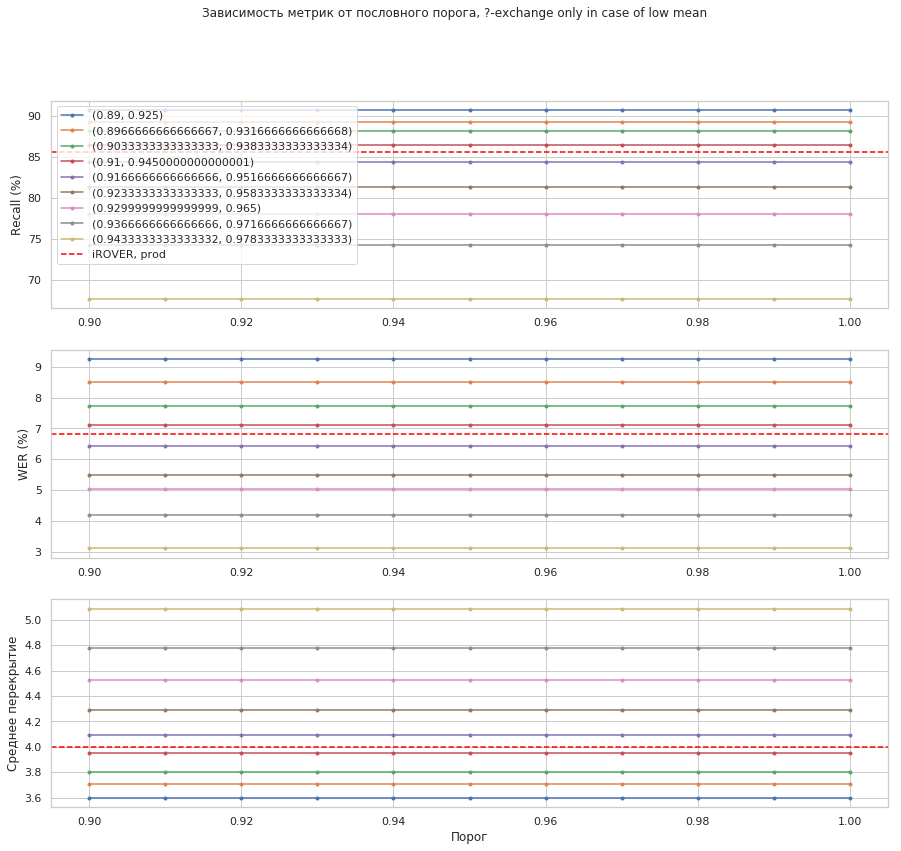

In [63]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
dif = 0.035
for key, value in scores_clf_score_by_word_mean.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label=str(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_mean.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_mean.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.show()